# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Основная задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Содержание**

1.  Изучение данных из файла

2.  Предобработка данных

3.  Расчёты и добавление результатов в таблицу

4.  Исследовательский анализ данных

    4.1.  Изучение параметров

    4.2.  Анализ редких и выбивающихся значений

    4.3.  Изучение TOП 10 населенных пунктов по количеству объявлений

    4.4.  Сравнение выводов по квартирам в центре и общим выводам по всем населенным пунктам

5.  Общий вывод

6.  Чек-лист готовности проекта


## Изучение данных из файла

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# обработка предупреждений
import warnings
warnings.filterwarnings('ignore')

# открытие файла 'real_estate_data.csv'
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
# просмотр общей информации о файле
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [3]:
# подсчет пропусков
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [4]:
# подсчет дубликатов
data.duplicated().sum()


0

**Вывод**

В ходе изучения общей информации о файле были выявлены проблемы -  не подходящие типы данных и обнаружены пропущенные значения, поэтому необходимо:
- данные в столбце first_day_exposition (дата публикации) привести в формат дат;
- данные в столбцах floors_total (всего этажей в доме), balcony (число балконов), parks_around3000 (число парков в радиусе 3 км), ponds_around3000 (число водоёмов в радиусе 3 км) перевести в целочисленный формат;
- данные в столбце is_apartment (апартаменты) привести в булев тип и заменить пропуски на False, т.к. если это апартаменты, их владельцы обычно хорошо об этом знают;
- пропуски в столбце days_exposition заменить на значение, которое можно рассчитать по следующей логике: если нет длительности жизни объявления, то оно незакрыто. Незакрыто значит, что оно не было закрыто на момент подготовки выгрузки данных. Весьма вероятно, что дата выгрузки данных совпадает с датой публикации самого нового объявления в таблице. Поэтому, считаем датой выгрузки самую позднюю дату публикации, отнимаем от нее дату создания объявления и получаем длительность жизни объявлений для ситуаций, когда они пропущены;
- пропуски в столбце balcony (число балконов) заменить на 0, т.к. если человек не указал число балконов — скорее всего, их нет.

- пропуски в столбцах ceiling_height, living_area, kitchen_area, cityCenters_nearest заменить на медианные значения;
- пропуски в столбце locality_name можно удалить, т.к. доля таких строк мала и не повляет на результаты исследования;
- для остальных столбцов с пропущенными значениями нет подходящих значений на замену и в анализе они не используются, поэтому можно оставить эти значения пустыми.


## Предобработка данных

In [5]:
# перевод данных в столбце first_day_exposition в формат дат
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
# замена пропусков в days_exposition
data.loc[data['days_exposition'].isna(), 'days_exposition'] = (data['first_day_exposition'].max() - data['first_day_exposition']).dt.days


In [6]:
# замена пропусков в столбцах balcony и is_apartment
data.loc[data['balcony'].isna(), 'balcony'] = 0
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

# перевод типа данных в столбце is_apartment в булевый
data['is_apartment'] = data['is_apartment'].astype('bool')

# создаем список из названий столбцов, где нужно заменить пропуски на медиану и обрабатываем циклом
col_list = ['ceiling_height', 'living_area', 'kitchen_area', 'floors_total', 'parks_around3000', 'ponds_around3000', 'cityCenters_nearest']
for col_name in col_list:
    data.loc[data[col_name].isna(), col_name] = data[col_name].median()
    
# преобразование вещественного типа данных в целочисленный
# создаем список с названиями столбцов и при помощи цикла меняем тип данных
col_list_2 = ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'cityCenters_nearest'] 
for name in col_list_2:
    data[name] = data[name].astype('int')
    
#удаляем пустые строки, в которых пропущено название населенного пункта
data = data.dropna(subset=['locality_name'])
# проверяем результат обработки
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition             0
dtype: int64

Преобразование формата данных и заполнение пропущенных значений произведено, так что данные готовы для проведения анализа.

## Расчёты и добавление результатов в таблицу

In [7]:
# добавление столбца с ценой квадратного метра
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'] = data['price_per_meter'].astype('int')

# добавление столбцов с днем недели, месяцем и годом публикации объявления
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year


In [8]:
# создаем функцию для распределния объектов по категориям этажности
def floor_func(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
# создаем столбец с категориями
data['floor_name'] = data.apply(floor_func, axis=1)


In [9]:
# создание столбца с данными соотношения жилой и общей площади
data['living_per_total_area'] = data['living_area'] / data['total_area']

# создание столбца с данными соотношения площади кухни к общей
data['kitchen_per_total_area'] = data['kitchen_area'] / data['total_area']

data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_exposition,month_exposition,year_exposition,floor_name,living_per_total_area,kitchen_per_total_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755.0,57.0,120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,81.0,82920,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2,574.0,558.0,92785,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,3,234.0,424.0,408176,4,7,2015,другой,0.188679,0.057233
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48.0,121.0,100000,1,6,2018,другой,0.320000,0.410000


К исходному датафрейму были добавлены новые столбцы со следующими показателями:
- цена за 1 квадратный метр;
- день недели, месяц и годом публикации объявления;
- категории этажности (первый, последний, другой);
- соотношение жилой и общей площади;
- соотношения площади кухни к общей площади.

## Исследовательский анализ данных

### Изучение параметров

**Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.**

In [10]:
# список названий столбцов с необходимыми параметрами
param_list = ['total_area', 'price_per_meter', 'rooms', 'ceiling_height']

# вывод описания значений 
for n in param_list:
    print(data[n].describe())

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
count    2.365000e+04
mean     9.943180e+04
std      5.033794e+04
min      1.110000e+02
25%      7.661425e+04
50%      9.500000e+04
75%      1.142740e+05
max      1.907500e+06
Name: price_per_meter, dtype: float64
count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


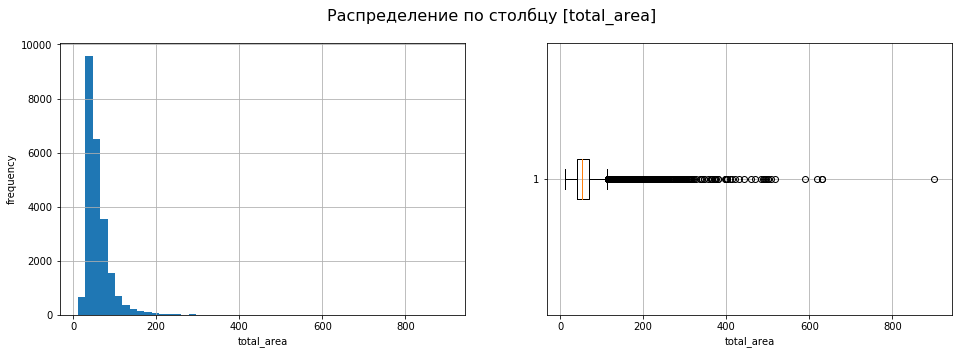

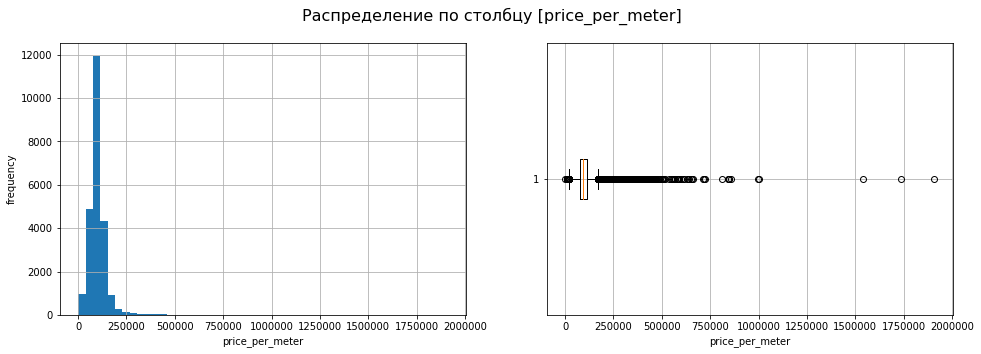

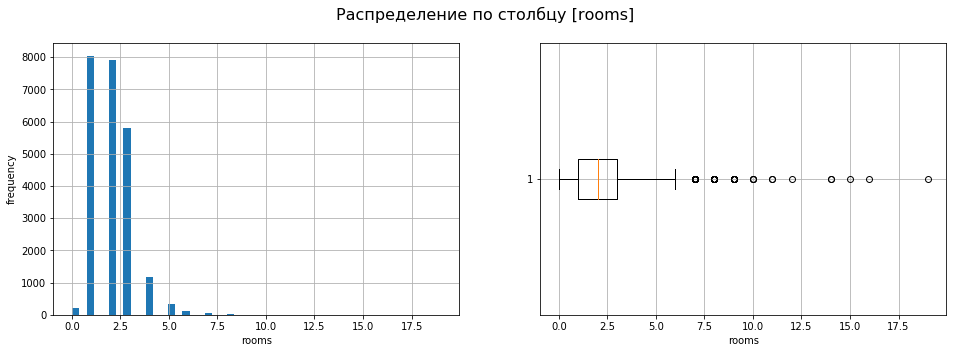

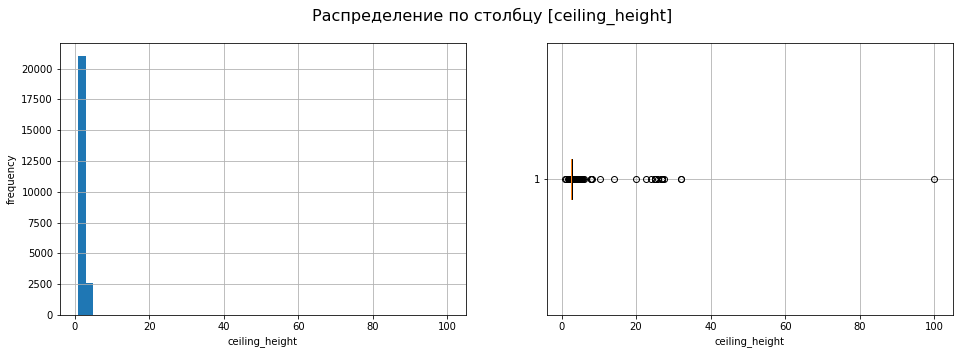

In [11]:
# визуализация распределения значений в column
def column_visible(df, column, bins, suptitle, xlabel, ylabel):

    plt.figure(figsize=(16,5)) # размер фигуры
    plt.suptitle(suptitle + ' [' + column + ']', fontsize=16) # название фигуры

    # первая фигура hist()
    plt.subplot(1, 2, 1) # выделим место в фигуре
    plt.hist(df[column], bins=bins)
    plt.xlabel(xlabel) # название оси x
    plt.ylabel(ylabel) # название оси y
    plt.grid(axis = 'both') # отображение сетки
    
    # вторая фигура boxplot()
    plt.subplot(1, 2, 2) # выделим место в фигуре
    plt.boxplot(df[column], vert=False)
    plt.xlabel(xlabel) # название оси x
    plt.grid(axis = 'both') # отображение сетки

    # вывод фигуры
    plt.show()

# в цикле создадим гистограммы для каждого из параметров
for i in param_list:
    column_visible(data, i, 50, 'Распределение по столбцу', i, 'frequency')
    
    

**Больше всего квартир с площадью до 100 м.кв., квартиры с большей площадью можно считать выбросами в данных и в дальнейшем исключить из анализа, чтобы эти значения не искажали результат. Стоимость квартир за 1 квадратный метр в основном колеблется от 77 тыс. до 114 тыс. руб. и в среднем составляет 99 тыс.руб. Чаще всего встречаются 1 и 2-х комнатные квартиры с высотой потолков 2.65 м.**


**Изучим время продажи квартир**

In [12]:
# вывод общей статистики
data['days_exposition'].describe()


count    23650.000000
mean       185.714419
std        233.455771
min          0.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1618.000000
Name: days_exposition, dtype: float64

In [13]:
# расчет среднего значения 
data['days_exposition'].mean()


185.71441860465117

In [14]:
# расчет медианы
data['days_exposition'].median()

94.0

**Изучение времени продажи квартир показало, что половина квартир продается за 3 месяца. До 25% квартир продается быстрее чем за один месяц и необычно долгим считается, если квартира продается дольше чем полгода.**

### Анализ редких и выбивающихся значений

Проведем последовательную фильтрацию для удаления выбросов в данных, для этого для каждого столбца ('total_area', 'price_per_meter', 'rooms', 'ceiling_height', 'days_exposition') найдем квартили и вычислим IQR.

In [16]:
# создаем список столбцов, по которым будет производиться фильтрация
filtr_list = ['total_area', 'price_per_meter', 'rooms', 'ceiling_height', 'days_exposition']

# напишем цикл, который будет последовательно перебирать нужные стлбцы и находить для них квартили
# создадим для удобства копию исходного датафрейма
df = data.copy()
for i in filtr_list:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3 - q1
    df = df.query('(@q1 - 1.5 * @iqr) <= {} <= (@q3 + 1.5 * @iqr)'.format(i))
    


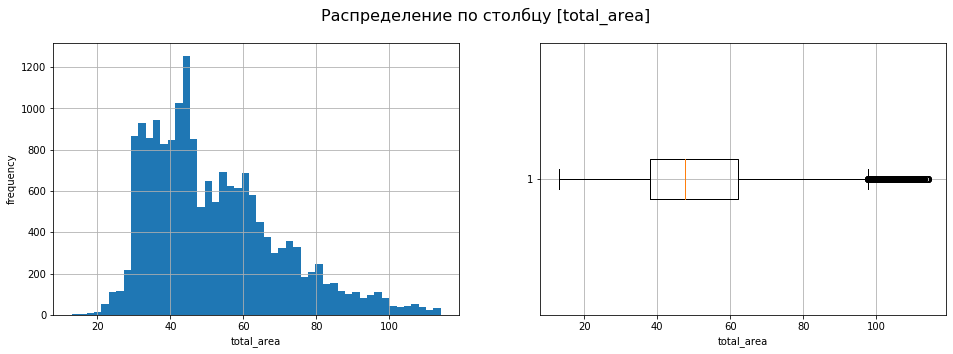

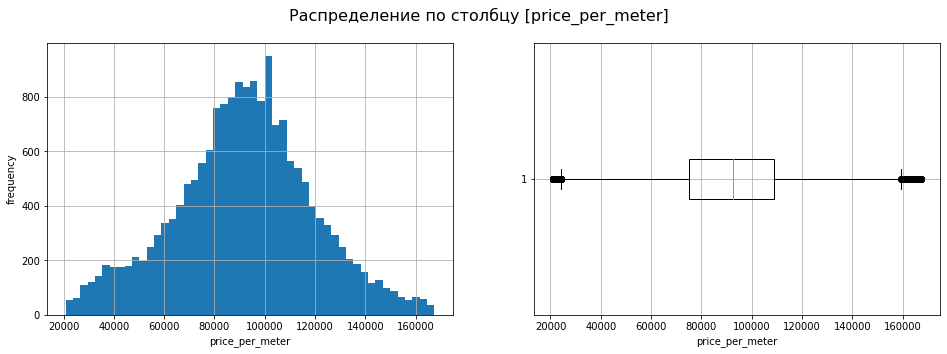

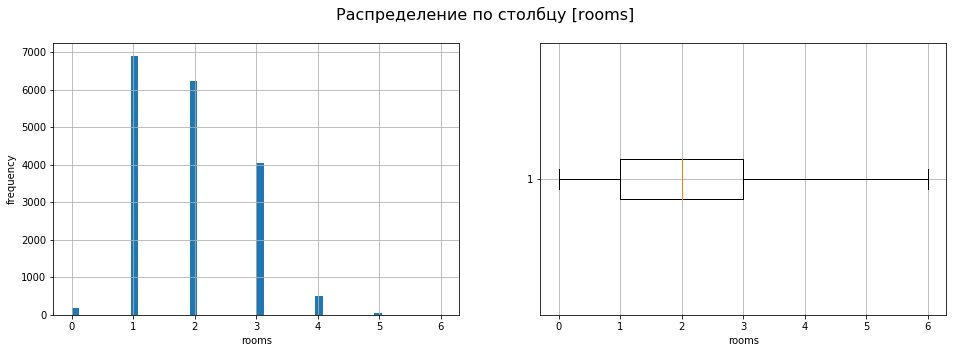

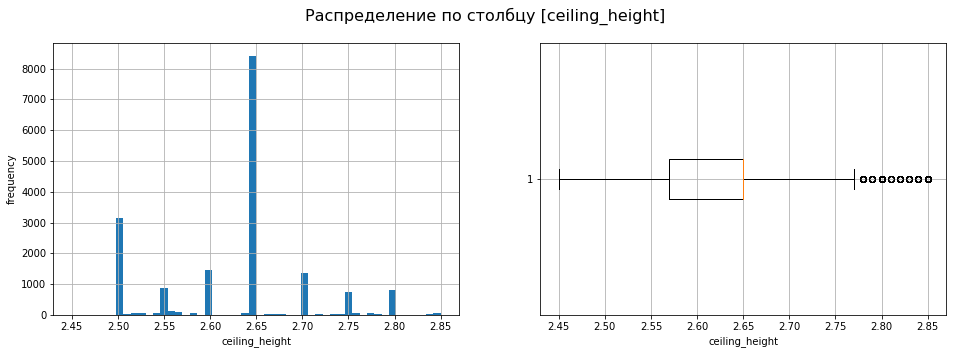

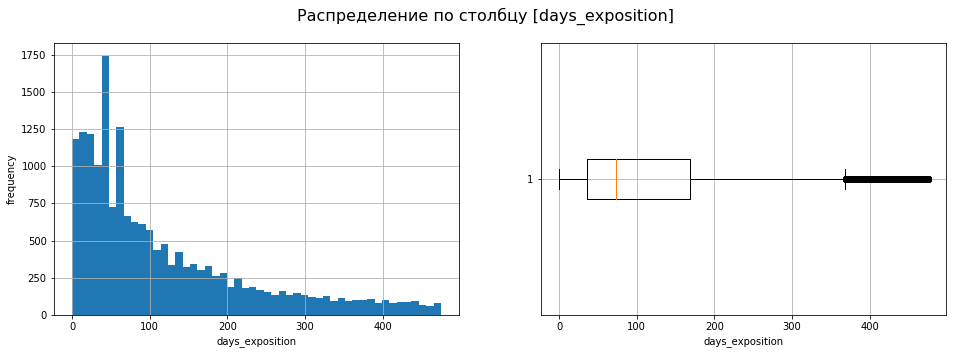

In [17]:
# Визуализируем очищенные от редких и выбивающихся значений данные уже имеющейся функцией column_visible
for i in filtr_list:
    column_visible(df, i, 50, 'Распределение по столбцу', i, 'frequency');

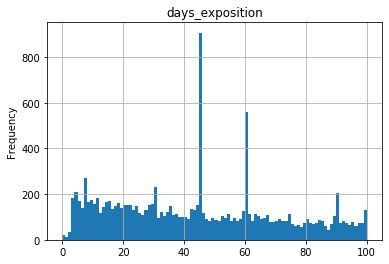

In [18]:
# рассмотрим на диаграмме с днями размещения объявлений промежуток до 100 дней более детально, т.к. на диаграмме выделяются 2 пика в этой области
data_days_exposition = data.query('days_exposition <= 100')
data_days_exposition['days_exposition'].plot(kind='hist', bins=100, grid=True, title='days_exposition', x='day');   

Теперь стало наглядно видно, что больше всего в продаже квартир с площадью 30-60 м.кв. и это однокомнатные и двухкомнатные квартиры. Стоимость за 1 м.кв. обычно колеблется где-то от 70 тыс. руб. до 110 тыс. руб. Самая распространенная высота потолка 2.65 м., а время жизни объявлений в основном примерно от 50 до 150 дней, т.е. вероятность продать квартиру меньше чем за 2 месяца очень велика.Видно, что больше всего объявлений зафиксировано на отметках 45 и 60 дней, что вероятнее всего объясняется правилами сроков размещения на площадках.


**Изучение факторов, влияющих на стоимость квартиры**

Для анализа взаимосвязи рассчитаем показатели корреляции между ценой и площадью, числом комнат и удаленностью от центра и выведем эти зависимости на экран

In [19]:
# рассчет коэффициента корреляции Пирсона
print(df['price_per_meter'].corr(df['total_area']))
print(df['price_per_meter'].corr(df['rooms']))
print(df['price_per_meter'].corr(df['cityCenters_nearest']))

-0.01061256473507915
-0.19374669256092
-0.17912019439787993


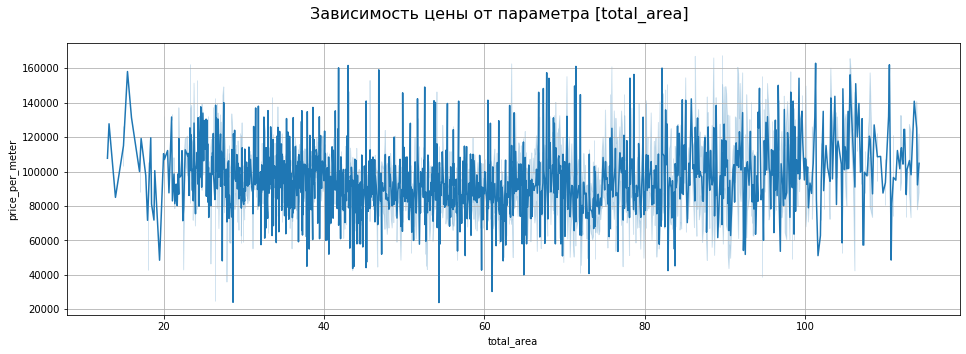

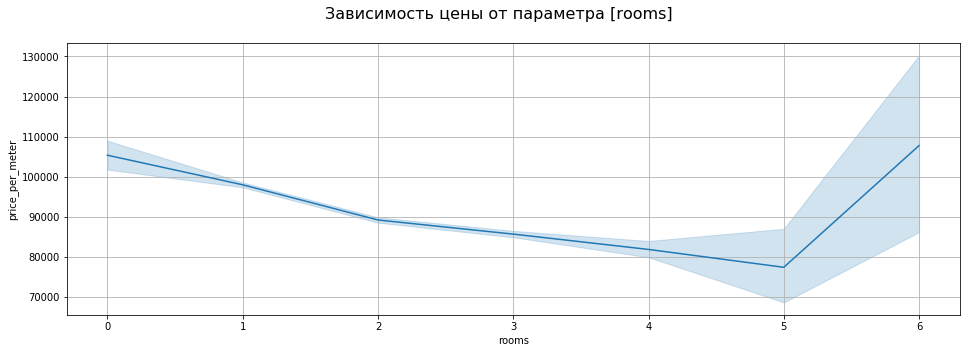

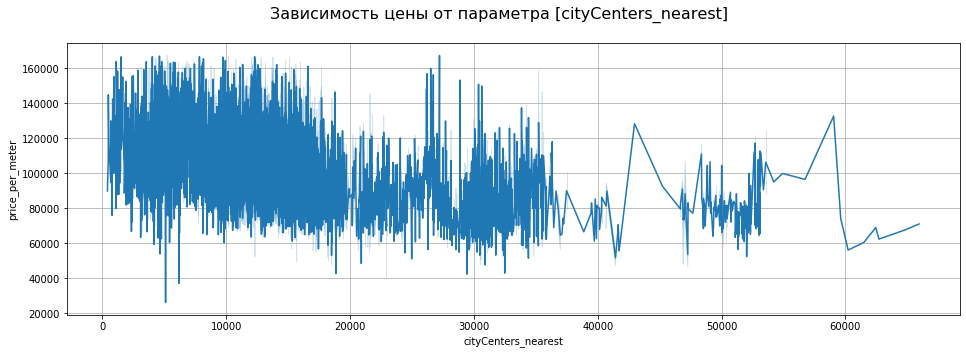

In [20]:
# cоздадим список с названиями нужных для анализа столбцов
corr_list = ['total_area', 'rooms', 'cityCenters_nearest']
# создадим новую функцию для вывода графиков зависимости цены от разных факторов
def column_visible2(df, column, bins, suptitle, xlabel, ylabel):

    plt.figure(figsize=(16,5)) # размер фигуры
    plt.suptitle(suptitle + ' [' + column + ']', fontsize=16) # название фигуры

    #lineplot()
    sns.lineplot(data=df, x = column, y = 'price_per_meter')
    plt.xlabel(xlabel) # название оси x
    plt.ylabel(ylabel) # название оси y
    plt.grid(axis = 'both') # отображение сетки
      
    # вывод фигуры
    plt.show()

#в цикле создадим графики для каждого из параметров
for column in corr_list:
    column_visible2(df, column, 50, 'Зависимость цены от параметра', column, 'price_per_meter')
    



**Как показли подсчет коэффициентов Пирсона и вывод lineplot линейная зависимиость между ценой 1 кв.м. квартиры и общей площадью очень слабая. Прослеживается обратная зависимость цены от количества комнат и удаленности от центра - дороже всего квадратный метр однокомнатных квартир и квартир,ближайших к центру.**

**Рассмотрим зависимость цены квартиры от этажа:**

(1, 200000)

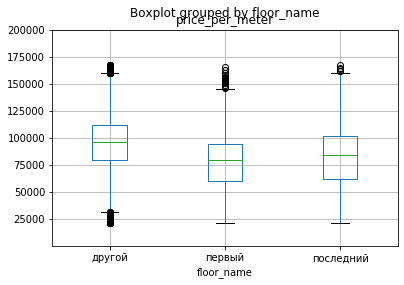

In [21]:
# построим боксплот 
df.boxplot(column='price_per_meter', by = 'floor_name');
plt.ylim(1,200000)

**Медианные значения цены за квадратный метр меньше на первом и последнем этажах.**

**Рассмотрим зависимость цены квартиры от даты размещения объявления: дня недели, месяца и года.**

In [22]:
# рассчет коэффициента корреляции Пирсона
print(df['price_per_meter'].corr(df['day_exposition']))
print(df['price_per_meter'].corr(df['month_exposition']))
print(df['price_per_meter'].corr(df['year_exposition']))

-0.004251318631489085
-0.005941484229349
0.08859660775013131


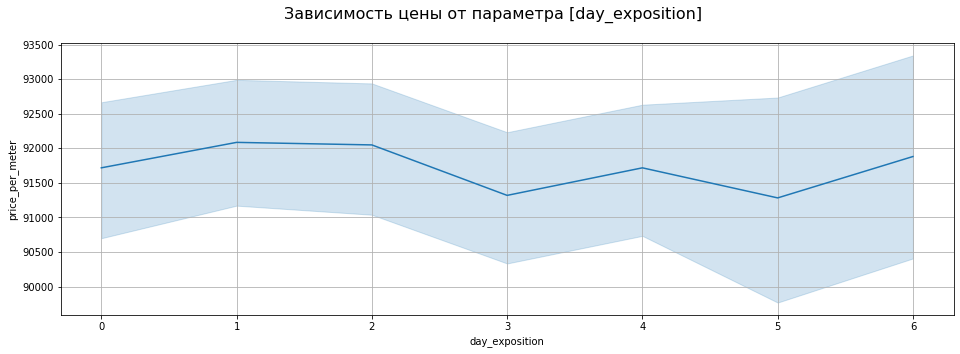

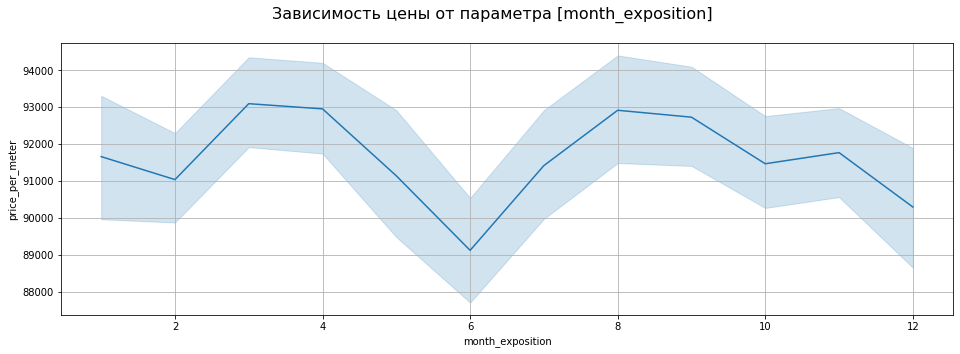

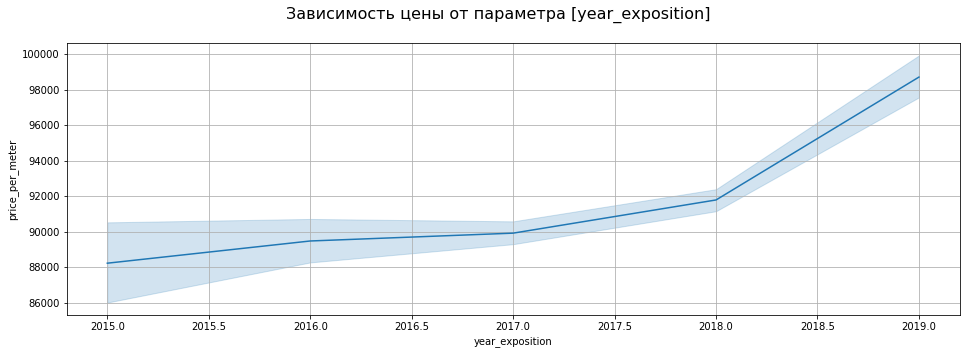

In [23]:
# добавим в список изучаемые параметры
date_list = ['day_exposition', 'month_exposition', 'year_exposition']

#в цикле создадим графики для каждого из параметров
for date_column in date_list:
    column_visible2(df, date_column, 50, 'Зависимость цены от параметра', date_column, 'price_per_meter')
    


**На основаниие коэффицента Пирсона и из графиков видно, что зависимость цены от дня размещения объявления практически не прослеживается. Относительно месяца продажи можно выделить некую сезоннсть -заметно падение цены с апреля по июнь, что, как можно предположить, связано с сезоном отпусков-падает спрос на квартиры, а вместе с ним и цена, так что самым выгодным месяцем для покупки можно назвать июнь, к осени цена растет, а вот зимой, видимо,к новогодним праздникам и предстоящему затишью на этом рынке вновь появляются скидки и бонусы-цены становятся ниже. Ну и с каждым годом цена за метр только увеличивается.**

### Изучение TOП 10 населенных пунктов по количеству объявлений

In [24]:
# сгруппируем датафрейм по населенным пунктам и посчитаем среднюю цену за метр кв. и количество объявлений
df_grouped = df.groupby('locality_name').agg({'price_per_meter':['mean', 'count']})
# переименуем названия колонок
df_grouped.columns=['price_per_meter_mean', 'count']
# выведем топ 10 населенных пунктов по кол-ву объявлений
display(df_grouped.sort_values(by='count', ascending=False).head(10))


,price_per_meter_mean,count
locality_name,,
Санкт-Петербург,104651.829398,11266
посёлок Мурино,85992.989583,480
посёлок Шушары,78568.497549,408
Всеволожск,66919.574850,334
посёлок Парголово,89914.042345,307
Колпино,75475.306397,297
Пушкин,100817.261993,271
деревня Кудрово,92640.992366,262
Гатчина,69071.984314,255


In [25]:
# выведем данные о населенных пунктах с самой высокой и низкой стоимостью жилья
display(df_grouped.query('price_per_meter_mean == price_per_meter_mean.max()'))
display(df_grouped.query('price_per_meter_mean == price_per_meter_mean.min()'))

,price_per_meter_mean,count
locality_name,,
Санкт-Петербург,104651.829398,11266


,price_per_meter_mean,count
locality_name,,
поселок городского типа Никольский,20847.5,2


**Так, самая высокая цена за квадратный метр среди населенных пунктов с самым большим количеством объявлений в Санкт-Петербурге, а самя низкая - в поселке городского типа Никольский.**

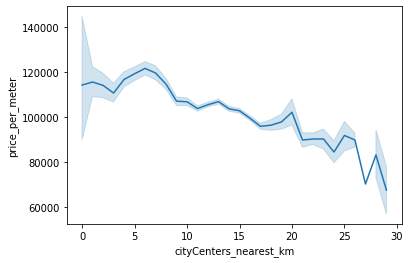

In [26]:
# выделим квартиры в Санкт-Петербурге
spb = df.query('locality_name == "Санкт-Петербург"')
# создаем столбец с расстоянием до центра в километрах
spb['cityCenters_nearest_km'] = (spb['cityCenters_nearest'] / 1000).round(0)
# сгруппируем данные по километрам и подсчитаем среднюю цену для каждого километра
df_cityCenters = spb.pivot_table(index='cityCenters_nearest_km', values='price_per_meter', aggfunc='mean')
# вывод графика зависимости цены от удаленности от центра
sns.lineplot(data=spb, x = 'cityCenters_nearest_km', y = 'price_per_meter')
plt.show()



**Граница, где график сильно меняется, начинается после 8 км., значит области, расположенные дальше, в центр уже не входят и видно, что цена для них становится ниже.**

### Сравнение выводов по квартирам в центре и общим выводам по всем населенным пунктам

Изучим уже знакомые параметры (площадь,цена за 1 м.кв., количество комнат, высота потолков) для центра Питера

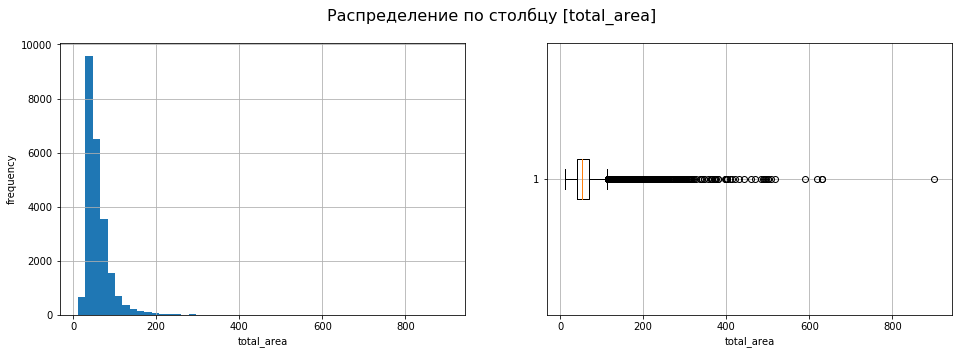

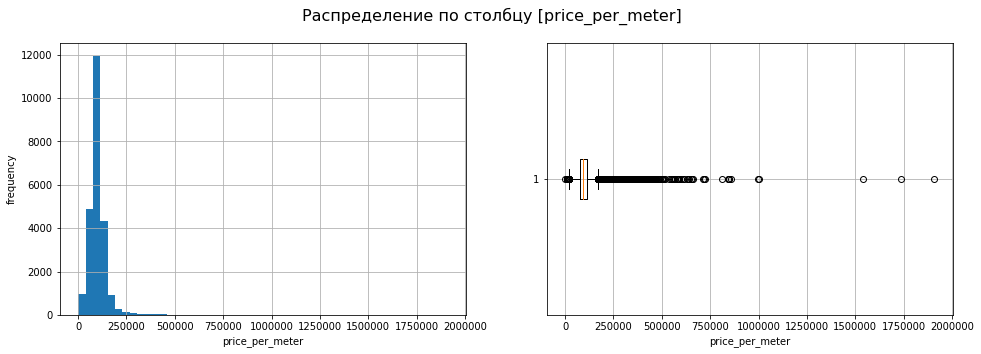

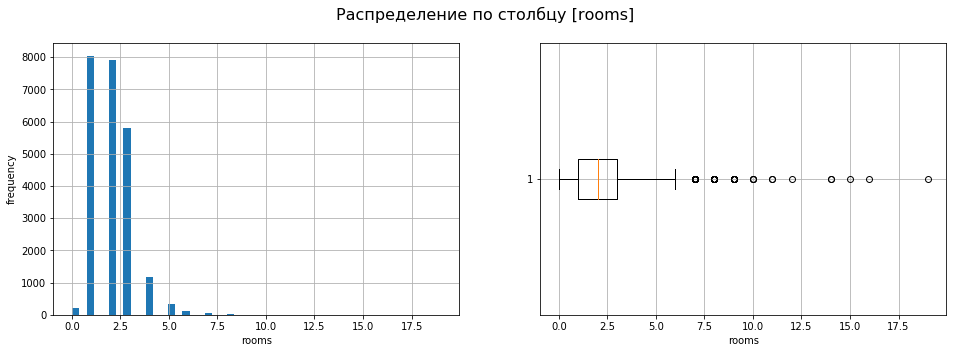

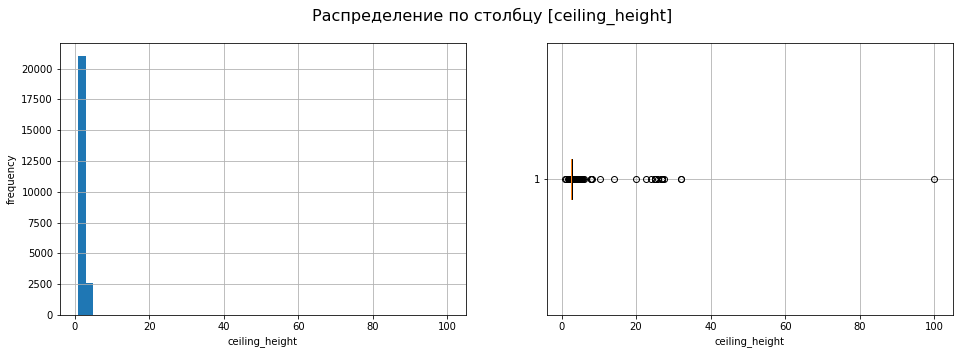

In [27]:
# выделим сегмент квартир в центре
spb_centere = spb.query('cityCenters_nearest_km <= 8')
# список названий столбцов с параметрами, которые необходимо изучить
param_list_spb_centre = ['total_area', 'price_per_meter', 'rooms', 'ceiling_height']
# в цикле создадим гистограммы для каждого из параметров
for i in param_list_spb_centre:
    column_visible(data, i, 50, 'Распределение по столбцу', i, 'frequency')


In [28]:
# вывод описания значений 
for n in param_list_spb_centre:
    print(spb_centere[n].describe())

count    1477.000000
mean       63.307068
std        22.205614
min        13.200000
25%        45.000000
50%        60.300000
75%        80.000000
max       114.200000
Name: total_area, dtype: float64
count      1477.000000
mean     117547.296547
std       23953.140764
min       26250.000000
25%       99484.000000
50%      116129.000000
75%      135578.000000
max      167441.000000
Name: price_per_meter, dtype: float64
count    1477.000000
mean        2.193636
std         0.932920
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64
count    1477.000000
mean        2.654997
std         0.075825
min         2.460000
25%         2.650000
50%         2.650000
75%         2.650000
max         2.850000
Name: ceiling_height, dtype: float64


**Большая часть квартир в центре, также как и для других областей с площадью  60 м.кв.,1 и 2-мя комнатами и высотой потолков 2,65 м., а вот цена за 1 м.кв. уже отличается,в центре она выше и составляет  116 тыс.руб.**

In [29]:
# рассчитаем коэф-ты корреляции Пирсона для следующих параметров
spb_centere[['price_per_meter', 'rooms', 'floor',  'cityCenters_nearest_km', 'day_exposition', 'month_exposition', 'year_exposition']].corr()

,price_per_meter,rooms,floor,cityCenters_nearest_km,day_exposition,month_exposition,year_exposition
price_per_meter,1.000000,-0.328371,0.279722,0.028425,0.017679,-0.042159,0.163847
rooms,-0.328371,1.000000,-0.085198,-0.199908,-0.012744,0.019312,-0.072784
floor,0.279722,-0.085198,1.000000,0.280380,0.037550,0.019069,0.017193
cityCenters_nearest_km,0.028425,-0.199908,0.280380,1.000000,0.017114,-0.008486,0.104102
day_exposition,0.017679,-0.012744,0.037550,0.017114,1.000000,0.030739,0.016238
month_exposition,-0.042159,0.019312,0.019069,-0.008486,0.030739,1.000000,-0.270233
year_exposition,0.163847,-0.072784,0.017193,0.104102,0.016238,-0.270233,1.000000


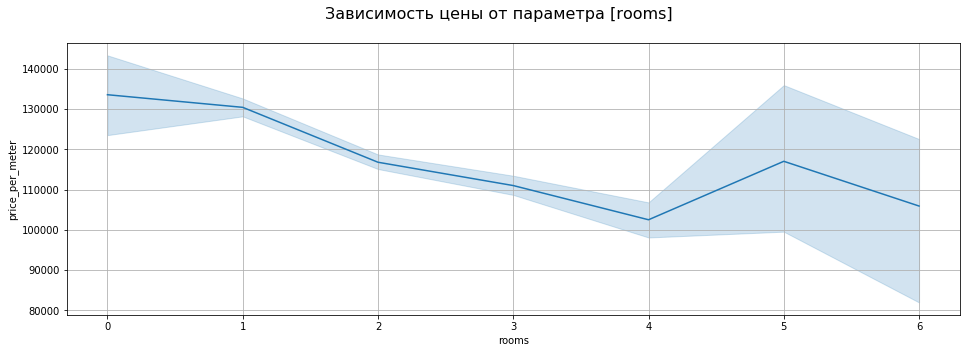

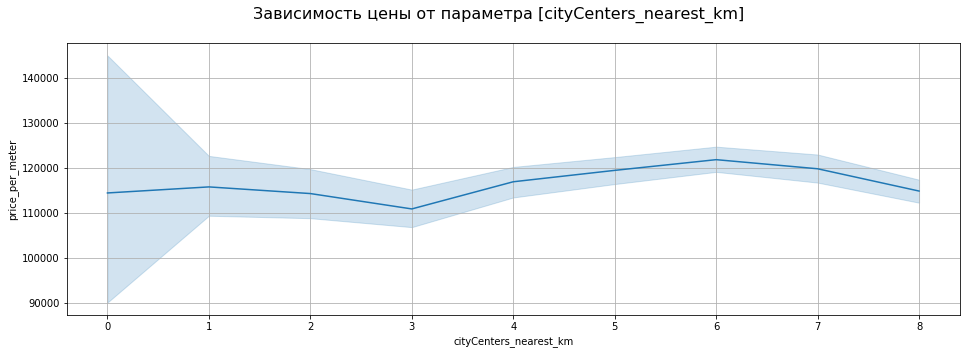

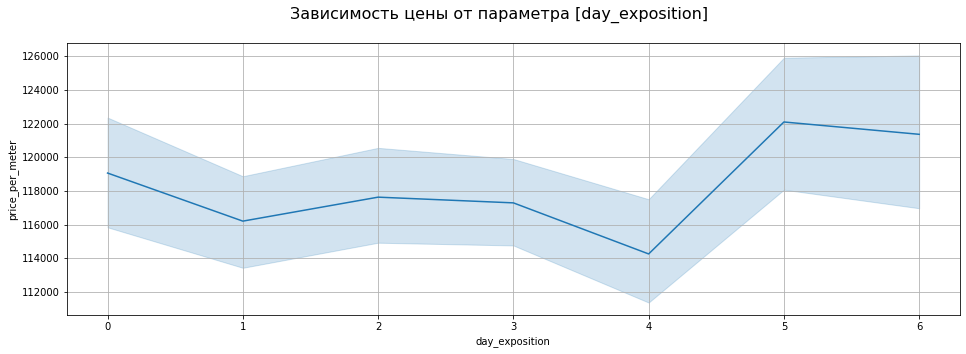

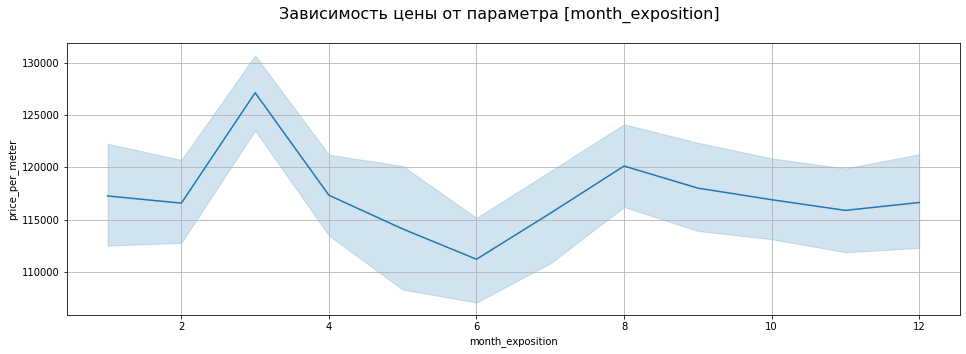

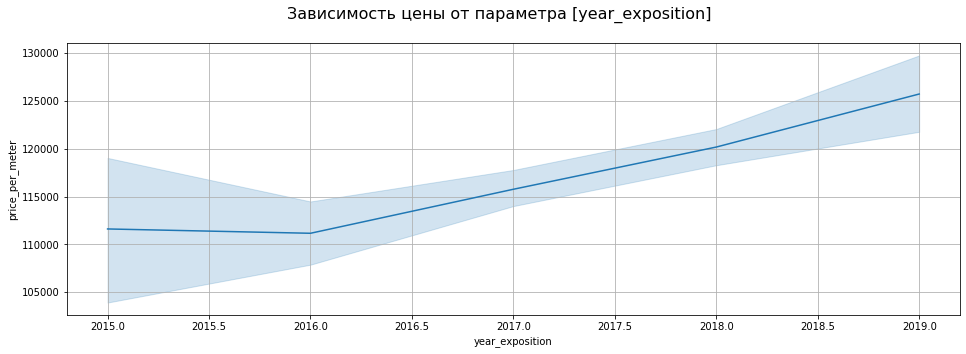

In [30]:
# cоздадим список с названиями нужных для анализа столбцов
corr_list2 = ['rooms',  'cityCenters_nearest_km', 'day_exposition', 'month_exposition', 'year_exposition']

#в цикле создадим графики для каждого из параметров
for column in corr_list2:
    column_visible2(spb_centere, column, 50, 'Зависимость цены от параметра', column, 'price_per_meter')
    

(1, 200000)

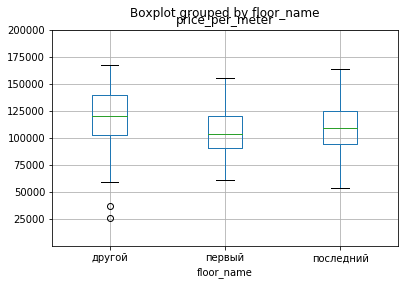

In [31]:
# для анализа зависимости цены от этажа выведем боксплот
# построим боксплот 
spb_centere.boxplot(column='price_per_meter', by = 'floor_name');
plt.ylim(1,200000)

**Видно, что зависимость от количесвта комнат в квартире, как и для всей области обратная, стоимость за 1 м.кв. для однокомнатных квартир выше. В зависимости от даты размещения объявления,как и в целом по области,заметно падение цены с апреля по июнь, и рост цены от года к году.
Зависимость от этажности аналогичная - первый и последние этажи дешевле.**




## Общий вывод

Перед проведением исследования параметров, влияющих на стоимость квартир в Санкт-Петербурге и соседних населённых пунктах потребовалась предобработка имеющихся данных - был преобразован тип данных и заменены пропущенные значения, а таже данные были почищены от выбросов и аномальных значений, чтобы исследование не было искажено. 

Для удобства в качестве показателя оценки стоимости жилья была рассчитана цена за 1 квадратный метр, был выделен день недели, месяц и год публикации объявления, а также этажи были объединены в категории (первый, последний, другой).


Были изучены следующие параметры как для всех населенных пунктов так и для центра Санкт-Петербурга (точки, удаленность которых не больше 8 км от центра):
- общая площадь квартиры;
- цена;
- число комнат;
- высота потолков;
- этажность;
- время продажи квартир;
- удаленность от центра;
- дата размещения объявления: день недели, месяц и год.

Анализ влияния этих факторов на стоимость показал, что как для центра Питера так и для других населенных пунктов результаты наблюдений аналогичны, кроме стоимости за 1 м.кв., в Питере она выше и составляет 116 тыс.руб, в то время как по всей области - 99 тыс. руб. 

Большинство квартир с площадью 60 м.кв.,1 и 2-мя комнатами и высотой потолков 2,65 м.

Время продажи квартир в половине случаев составляет 3 месяца.

Линейная зависимиость между ценой 1 кв.м. квартиры и общей площадью очень слабая. Прослеживается обратная зависимость цены от количества комнат и удаленности от центра - дороже всего квадратный метр однокомнатных квартир и квартир,ближайших к центру. Первый и последний этажи стоят дешевле. 

В зависимости от даты продажи можно выделить некую сезоннсть -заметно падение цены с апреля по июнь,так что самым выгодным месяцем для покупки можно назвать июнь, к осени цена растет, а вот зимой цены снова становятся ниже. Ну и с каждым годом цена за метр кв.только увеличивается.

Среди населенных пунктов с самым большим количеством объявлений выявлена самая высокая цена за 1 квадратный метр в Санкт-Петербурге (105 тыс.руб.), а самая низкая - в в поселке городского типа Никольский (21 тыс.руб.).

**Таким образом, в качестве ключевых параметров, влияющих на рыночную стоимость квартиры можно установить следующие:**

- **удаленность от центра;**
- **количество комнат;**
- **этаж;**
- **месяц и год продажи.**